# Generate images set out of original lunar DEM tile (60 m/pix)
download file: 

In [ ]:
!wget -P ../data/ http://pds-geosciences.wustl.edu/lro/lro-l-lola-3-rdr-v1/lrolol_1xxx/data/sldem2015/tiles/jp2/sldem2015_512_00n_30n_000_045.jp2

In [1]:
from PIL import Image
import time
Image.MAX_IMAGE_PIXELS = 353894500
                             
import input_data_gen as igen
import utils.processing as proc
data_path='../data/'
# Read source image.
img = Image.open(data_path + "/sldem2015_512_00n_30n_000_045.jp2")

# [Min long, max long, min lat, max lat] dimensions of source image.
source_cdim = [0., 45., 0., 30.]

In [2]:
# Read the Robbins dataset (stored under /catalogues)
craters = igen.ReadRobbinsCraterCSV(filename="catalogues/RobbinsLunarCraters.csv", n=2e6) #import all cataqlog
craters = igen.ResampleCraters(craters, source_cdim) #crop relevant part
craters.tail()

,Long,Lat,Diameter (km)
16214,29.21150,29.9889,1.06136
16215,5.13845,29.9943,1.00629
16216,33.69420,29.9946,1.70762
16217,3.58091,29.9950,1.31853
16218,2.29662,29.9998,1.15419


In [3]:
fn = '../data/test_SLDEM1'
sub_cdim = [0., 20., 0., 30.]

# If True, script prints out the image it's currently working on.
verbose = True

# Sample subset of image.  Co-opt igen.ResampleCraters to remove all
# craters beyond cdim (either sub or source).
if sub_cdim != source_cdim:
    img = igen.InitialImageCut(img, source_cdim, sub_cdim)

craters = igen.ResampleCraters(craters, sub_cdim)

start_time = time.time()

# Generate input images: 
igen.GenDataset(img, craters, fn, rawlen_range = [300, 3000], 
                cdim=sub_cdim, amt=10, verbose=True)

#     # Generate input images.
#     igen.GenDataset(img, craters, outhead, rawlen_range=rawlen_range,
#                     rawlen_dist=rawlen_dist, ilen=ilen, cdim=sub_cdim,
#                     arad=R_km, minpix=minpix, tglen=tglen, binary=True,
#                     rings=True, ringwidth=ringwidth, truncate=truncate,
#                     amt=amt, istart=istart, verbose=verbose)

elapsed_time = time.time() - start_time
if verbose:
    print("Time elapsed: {0:.1f} min".format(elapsed_time / 60.))

Generating img_00
Generating img_01
Generating img_02
Generating img_03
Generating img_04
Generating img_05
Generating img_06
Generating img_07
Generating img_08
Generating img_09
Time elapsed: 0.0 min


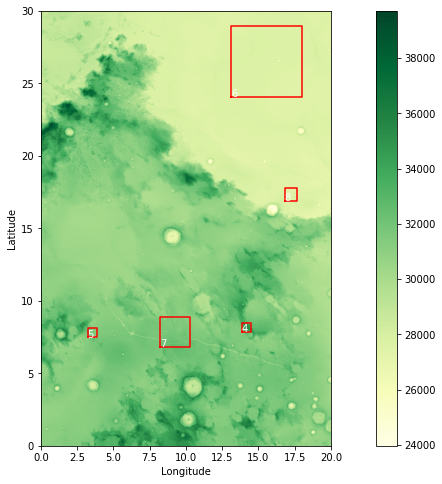

In [ ]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
gen_imgs = h5py.File(fn + '_images.hdf5', 'r')
sample_data = {'imgs': [gen_imgs['input_images'][...].astype('float32'),
                        gen_imgs['target_masks'][...].astype('float32')]}
%matplotlib inline
# See 5 images of the set we produced: 
show_subset = np.random.choice(range(len(gen_imgs['cll_xy'])),size=5, replace=False)
fig = plt.figure(figsize=[16, 8])
dem_map = plt.imshow(img, extent=sub_cdim, aspect="equal", cmap="YlGn")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
for i in show_subset:
  llon,rlon,llat,ulat=gen_imgs['longlat_bounds']['img_{:02d}'.format(i)][...]
  h1,=plt.plot([llon, llon, rlon, rlon, llon],[llat, ulat, ulat, llat, llat],'r')
  plt.text(llon,llat,str(i), color='w')

plt.colorbar()
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
rmoon=1737 #km
kmperdeg = 2*np.pi*rmoon/360 # km per degree transformation

def plot_map_w_scalebar2(ax,train_imgs,im_num):
  im_lims = train_imgs['longlat_bounds']['img_{:02d}'.format(im_num)][...] 
  plt.imshow(train_imgs['input_images'][im_num][...], extent=im_lims, origin='upper', 
             cmap='YlGn', aspect='equal') #, vmin=50, vmax=150
#   plt.imshow(1-train_imgs['target_masks'][im_num][...], alpha=0.2, extent=im_lims, 
#              origin='upper', cmap='Greys_r', aspect='equal')
#   np.cos(np.deg2rad(im_lims[2:].mean()))
  plt.title('Image #{} with target masks'.format(im_num))
  l,r=plt.xlim()
  barlength = 0.3*(r-l)
  bartext = '{:2.1f} km'.format(barlength*kmperdeg)
  bar = AnchoredSizeBar(ax.transData, barlength, bartext, 4)
  ax.add_artist(bar)
  ax.grid()
  return im_lims
    
fig2 = plt.figure(figsize=[16, 8])
for i, im_num in enumerate(show_subset):
  ax=plt.subplot(len(show_subset)//5,5,i+1)
  plot_map_w_scalebar2(ax,gen_imgs,im_num)

In [36]:
# help(h5py.File)
gen_imgs['input_images']

<HDF5 dataset "input_images": shape (10, 256, 256), type "|u1">

In [ ]:

%matplotlib inline


In [ ]:
ls -lh ../data/test*